## Example

In [1]:
from codec import *
#Una opcion para estructurar el file codec es armar una clase "Codec"que tenga de metodos a "encoder" y a "decoder"
# "encoder" y "decoder" comparten constantes que pueden ser atributos de la clase Codec.

from rawfile import RawFile
import warnings

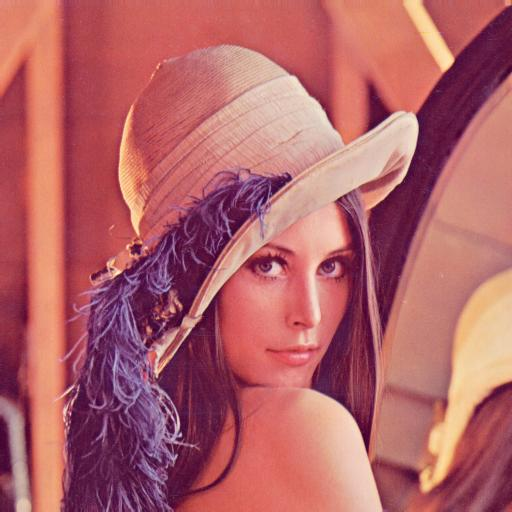

In [2]:
input_file = '../images/lena.png' # file a comprimir
image = Image.open(input_file)
image = image.convert('YCbCr')
image

(32, 32)


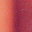

In [3]:
from PIL import Image

input_file = '../images/lena.png'
image = Image.open(input_file)

idx = 50
cropped_image = image.crop((0+idx, 0+idx, 32+idx, 32+idx))

print(cropped_image.size)
cropped_image

In [4]:
# Save the cropped image as a PNG
output_file = '../images/lena_cropped.png'
cropped_image.save(output_file)

print(f"Cropped image saved as {output_file}")


Cropped image saved as ../images/lena_cropped.png


# Algorithm 1: Encoder


In [5]:
input_file = '../images/lena_cropped.png' # file a comprimir
output_file = 'lena_cropped.fif' # path para archivo comprimido
max_error = 0.1 
basis_index = 0  # Example value for basis index

with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    code(input_file = input_file,
         output_file = output_file,
         max_error = max_error,
         basis_index = basis_index,
     #    min_n = 512,
     #    max_n = 512
         )

min_n = 8, max_n = 32
image size: (32, 32)
Image Mode: YCbCr, Depth: 3, Width: 32, Height: 32
3sBiiBBBBB b'FIF' 2 32 32 3 0 0 8 32 

Initializing omp_dict[32] with matrix A of shape (1024, 256)
 image_data.flatten().shape (1024,)
A.shape: (1024, 256), y.shape(1024,)
 image_data.flatten().shape (1024,)
A.shape: (1024, 256), y.shape(1024,)
 image_data.flatten().shape (1024,)
A.shape: (1024, 256), y.shape(1024,)
x: [(32, array([ 0.00000000e+00,  3.40062626e+11,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e

# Algorithm 2: Decoder

<font color="red">Input </font>: input_file, output_file  
<font color="red">Output </font>: decoded_image

1. Open the raw file and read header with MAGIC_NUMBER, version, w, h, depth, A_id, bi, min_n, max_n
2. Initialize image data matrix with zeros

3. For each color channel (depth):
   3.1 Decode the blocks using the OMP recursive decoder
   3.2 Reconstruct the image from decoded blocks

4. Convert YCbCr to RGB if needed
5. Save the decoded image to output_file

In [6]:
input_file = 'lena_cropped.fif'
output_file = 'lena_cropped_reconstructed.png'
decode(input_file, output_file)

fmt = 3sBiiBBBBB
size read: 17
data read: b'FIF\x02\x00\x00\x00 \x00\x00\x00 \x03\x00\x00\x08 '
udata read: (b'FIF', 2, 32, 32, 3, 0, 0, 8, 32)
header: FIF, 2, 32, 32, 3, 0, 0, 8, 32
iterations: 1, image_data.shape:(32, 32, 3)
fmt = B
size read: 1
data read: b'\x83'
udata read: (131,)
x.shape: (256,)

 (pos, value) pairs:

fmt = B
size read: 1
data read: b'\x01'
udata read: (1,)
fmt = f
size read: 4
data read: b'R\x9eZ\xa0'
udata read: (340062633984.0,)
pos: 1
value: 340062633984.0

fmt = B
size read: 1
data read: b','
udata read: (44,)
fmt = f
size read: 4
data read: b'\xcc\xec\x99\x13'
udata read: (-124045464.0,)
pos: 44
value: -124045464.0

fmt = B
size read: 1
data read: b'Z'
udata read: (90,)
fmt = f
size read: 4
data read: b'\xcb\xfd\x1c\x97'
udata read: (-33175854.0,)
pos: 90
value: -33175854.0

fmt = B
size read: 1
data read: b'\x7f'
udata read: (127,)
fmt = f
size read: 4
data read: b'K\x1f\xfa\xb6'
udata read: (10484406.0,)
pos: 127
value: 10484406.0

fmt = B
size read: 1
dat